# Fine-Tuning MI

In [1]:
import torch
from torch.utils.data import DataLoader
import json
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW

In [2]:
## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory / 1024**3
    r = torch.cuda.memory_reserved(0) / 1024**3
    a = torch.cuda.memory_allocated(0) / 1024**3
    print(f"Total Memory: {t:.2f} GB\n"
          f"Reserved Memory: {r:.2f} GB ({(100*(r/t)):.2f}%)\n"
          f"Remaining Memory: {t-r:.2f} GB ({(100*(t-r)/t):.2f}%)\n"
          f"---------------------------------\n"
          f"Allocated Memory: {a:.2f} GB ({(100*(a/t)):.2f}%)\n"
          f"Percent of Reserved Allocated: {(100*(a+1e-9)/(r+1e-9)):.2f}%\n")

In [3]:
## Model and tokenizer
model = GPTNeoXForCausalLM.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-1.4B-deduped",
  revision="step143000",
  cache_dir="./pythia-1.4B-deduped/step143000",
)

model_name = "EleutherAI/pythia-1.4B-deduped"
model_revision = "step143000"
model_cache_dir = "./pythia-1.4B-deduped/step143000"

device = "cuda" if torch.cuda.is_available() else "cpu"

# model.half()
model.eval()
model.to(device)
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 5.38 GB (34.13%)
Remaining Memory: 10.39 GB (65.87%)
---------------------------------
Allocated Memory: 5.37 GB (34.02%)
Percent of Reserved Allocated: 99.68%



In [4]:
# Just a simple deduping for now...can look into how EleutherAI did it when we scale it up
dataset = list(set(entry["text"] for entry in load_dataset("wk1/the_pile_val.py", split="validation[:1%]")))
training_dataset = dataset[:len(dataset)//2]
validation_dataset = dataset[len(dataset)//2:]
print(len(training_dataset))

No config specified, defaulting to: the_pile_val/all
Found cached dataset the_pile_val (/home/ubuntu/.cache/huggingface/datasets/the_pile_val/all/0.0.0/33c9237089c5fb09f83b2ab7ac73d703de97fc4d122e4b82a7777d85b0919e30)


1073


In [5]:
from transformers import Trainer, TrainingArguments
def collate_fn(batch):
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
    }
model.config.use_cache = False
training_args = TrainingArguments(output_dir="fine-tuning",
                                  num_train_epochs=3,
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,
                                  gradient_accumulation_steps=10,
                                  gradient_checkpointing=True,
                                  # fp16=True,
                                  optim="adafactor",
                                  )
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=training_dataset,
                  eval_dataset=validation_dataset,
                  tokenizer=tokenizer,
                  data_collator=collate_fn,
                )

In [6]:
trainer.train()

/tmp/ipykernel_4708/2895963121.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Step,Training Loss,Validation Loss


TrainOutput(global_step=321, training_loss=1.587786142699815, metrics={'train_runtime': 2502.6099, 'train_samples_per_second': 1.286, 'train_steps_per_second': 0.128, 'total_flos': 1.8188813157605376e+16, 'train_loss': 1.587786142699815, 'epoch': 2.99})

In [7]:
bs = 8
## Dataloader 
def collate_fn(batch):
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return tokens_padded
training_dataloader = DataLoader(training_dataset, batch_size = bs, collate_fn=collate_fn, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = bs, collate_fn=collate_fn, shuffle = True)
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 12.89 GB (81.75%)
Remaining Memory: 2.88 GB (18.25%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 41.78%



In [8]:
nbatches = 200 ## Number of batches to gather data on. Number of data points is ns * nbatches
samplelength = 20 ## How long are the sequences we take from the training and validation sets.

In [9]:
## Training dataset information
training_sum_perplexity = torch.zeros((nbatches, bs))
for batchno, training_x in enumerate(training_dataloader):
    if batchno >= nbatches:
        break
    with torch.no_grad():       
        ## Get predictions on training data                       
        training_x = training_x[:,:samplelength].to(device).detach()
        mask  = (training_x>0).detach()     

        model.train(False)
        logits_training = model(input_ids=training_x, attention_mask = mask)

        ## Find sum of log likelihood of each sequence
        for batch in range(bs):
            seq_logits = torch.zeros((len(training_x[0])))
            
            ## Find sum of log likelihood of each sequence
            for idx, w in enumerate(training_x[min(batch,training_x.shape[0]-1),]):
                if training_x[min(batch,training_x.shape[0]-1),idx] == 0:
                    break
                seq_logits[idx] = logits_training.logits[min(batch,training_x.shape[0]-1),idx,w]
            
            ## Case for when we reach the end of the sequence
            if training_x[min(batch,training_x.shape[0]-1),idx] != 0:
                idx += 1

            ## Compute perplexity
            training_sum_perplexity[batchno, min(batch,training_x.shape[0]-1)]= torch.sum(seq_logits[:idx]-torch.log(1+torch.exp(seq_logits[:idx])))/idx

            ## Clean up 
            del seq_logits
            torch.cuda.empty_cache()
            torch.cuda.synchronize()

        ## Cleaning up
        del training_x, mask, logits_training
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    if batchno % 20 == 0:
        print("Training batch no. ", batchno)  
        print("Memory after training")
        mem_stats()
        print()

Training batch no.  0
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  20
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  40
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  60
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batc

In [10]:
validation_sum_perplexity = torch.zeros((nbatches, bs))
for batchno, validation_x in enumerate(validation_dataloader):
    if batchno >= nbatches:
        break
    with torch.no_grad():               
        ## Get predictions on validation data                 
        validation_x = validation_x[:,:samplelength].to(device).detach()
        mask  = (validation_x>0).detach()                                     

        model.train(False)
        logits_validation = model(input_ids=validation_x, attention_mask = mask)

        ## Find sum of log likelihood of each sequence
        for batch in range(bs):
            seq_logits = torch.zeros((len(validation_x[0])))

            ## Find logits of each word in the sequence
            for idx, w in enumerate(validation_x[min(batch,validation_x.shape[0]-1),]):
                if validation_x[min(batch,validation_x.shape[0]-1),idx] == 0:
                    break
                seq_logits[idx] = logits_validation.logits[min(batch,validation_x.shape[0]-1),idx,w]
            if validation_x[min(batch,validation_x.shape[0]-1),idx] != 0:
                idx += 1
            validation_sum_perplexity[batchno, min(batch,validation_x.shape[0]-1)]= torch.sum(seq_logits[:idx]-torch.log(1+torch.exp(seq_logits[:idx])))/idx

            ## Clean up 
            del seq_logits
            torch.cuda.empty_cache()
            torch.cuda.synchronize()


        ## Cleaning up
        del validation_x, mask, logits_validation
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    if batchno % 20 == 0:
        print("Training batch no. ", batchno)  
        print("Memory after training")
        mem_stats()
        print()

Training batch no.  0
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  20
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  40
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batch no.  60
Memory after training
Total Memory: 15.77 GB
Reserved Memory: 5.41 GB (34.30%)
Remaining Memory: 10.36 GB (65.70%)
---------------------------------
Allocated Memory: 5.39 GB (34.16%)
Percent of Reserved Allocated: 99.58%


Training batc

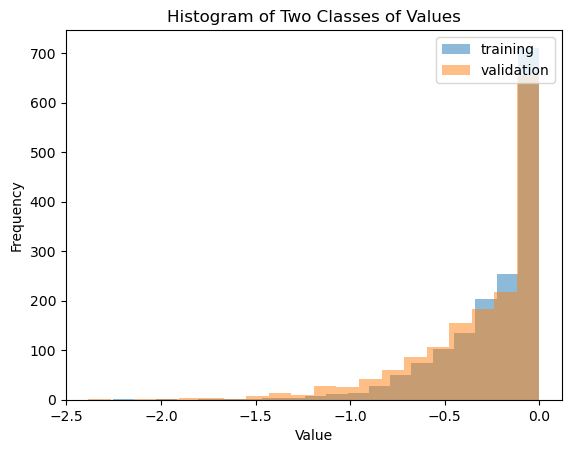

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# generate two sets of random values
with torch.no_grad():
    valuestraining   = torch.flatten(training_sum_perplexity) 
    valuesvalidation = torch.flatten(validation_sum_perplexity)

# create a figure and axis object
fig, ax = plt.subplots()

# plot a histogram of the first set of values with 20 bins
ax.hist(valuestraining, bins=20, alpha=0.5, label='training')

# plot a histogram of the second set of values with 20 bins
ax.hist(valuesvalidation, bins=20, alpha=0.5, label='validation')

# add a legend to the plot
ax.legend(loc='upper right')

# add labels and a title to the plot
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Two Classes of Values')

# show the plot
plt.show()

tensor(-2.3828) tensor(0.)


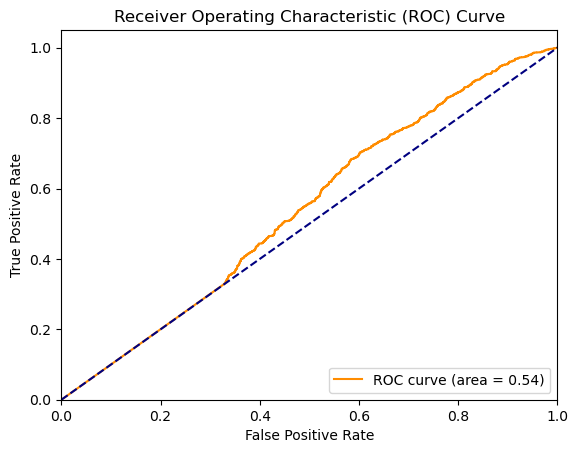

In [12]:
from sklearn.metrics import roc_curve, auc

## Scale all values to be between 0 and 1
st = min(valuestraining.min(),valuesvalidation.min())
end = max(valuestraining.max(),valuesvalidation.max())
print(st,end)

y_scores =  torch.cat((valuestraining, valuesvalidation))
y_scores = y_scores-min(y_scores)
y_scores = y_scores/max(y_scores)
y_true   = [1 for _ in range(len(valuestraining))] + [0 for _ in range(len(valuesvalidation))]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("test.png")